In [53]:
#Importing Modules
from Feedforward_Network import Feedforward_Network
from collections import Counter
import re
import numpy as np
import string
import random
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import numpy as np
import itertools
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
#Removes symbols from the text
def preprocess(text):
    exclude = set(string.punctuation)
    text = text.lower()
    text = ''.join(ch for ch in text if ch not in exclude)
    return text

In [3]:
# Takes a line from the file and returns the tweet split into a list of strings and its sentiment label
def get_words_and_label(line):
    line = line.strip().split(',', 3)
    label = int(line[1])
    #print(line)
    tword = preprocess(line[3]).split()
    word = []
    for w in tword:
        if (w!= ""):
            word += [w]
    #print(word)
    return label, word

In [4]:
# Takes a training / testing file and fills up a matrix of inputs X and outputs y and returns X, y
def fill_matrix(file, good_probs, bad_probs, total_lines):
    X = np.empty([total_lines, 140])
    y = np.empty([total_lines, 2])
    for i, line in enumerate(file):
        label, words = get_words_and_label(line)
        if label == 1:
            y[i] = 1, 0
        else:
            y[i] = 0, 1
        
        for j in range(70):
            if j >= len(words):
                X[i][2*j] = 0
                X[i][2*j+1] = 0
            else:
                X[i][2*j] = good_probs[words[j]] * 100
                X[i][2*j+1] = bad_probs[words[j]] * 100
    return X, y

In [5]:
#Set up neural network and training/testing files
sentiment_predictor = Feedforward_Network(140, 25, 2)
train_file = list(open("data/good20000_1", 'r', encoding="utf8")) + list(open("data/bad20000_1", 'r', encoding="utf8"))
test_file = list(open("data/good20000_2", 'r', encoding="utf8")) + list(open("data/bad20000_2", 'r', encoding="utf8"))

In [6]:
#Set up counters for good sentiment and bad sentiment categories
bad_count = Counter()
good_count = Counter()
total_lines_train = len(train_file)
total_lines_test = len(test_file)
total_good_lines = 0
total_bad_lines = 0

In [7]:
x = 0

#Add words to counters
for line in train_file:
    label, words = get_words_and_label(line)
    if x < 10:
        print(words)
        x += 1
    
    if label:
        total_good_lines += 1
        count_tracker = good_count
    else:
        total_bad_lines += 1
        count_tracker = bad_count
        
    for w in words:
        count_tracker[w] += 1

['im', 'happy', 'thats', 'all', 'haha']
['fuckin', 'finally', 'watching', 'true', 'blood']
['1408', 'is', 'not', 'one', 'of', 'john', 'cusacks', 'best', 'movies', 'its', 'interesting', 'but', 'i', 'want', 'him', 'smiling', 'and', 'romantic']
['we', 'are', 'on', 'our', 'way', 'of', 'crossing', '80', 'in', 'half', 'an', 'hour', 'nervous', 'haha', 'making', 'sure']
['blocknurse', 'awwww', 'thanks', 'donna']
['andyhart', 'today', 'better', 'than', 'yesterday', 'then', 'it', 'is', 'friday']
['devilsrefugee', 'yep', 'but', 'its', 'so', 'damn', 'good', 'we', 'have', 'to', 'love', 'it', 'its', 'unaustralian', 'if', 'we', 'dont']
['httptwitpiccom5ewkv', 'i', 'cant', 'wait', 'till', 'i', 'finish']
['wishing', 'i', 'had', 'not', 'stayed', 'up', 'until', '4', 'in', 'the', 'morning', 'this', 'midlife', 'crisis', 'is', 'going', 'to', 'kill', 'me']
['tj', 'is', 'helping', 'his', 'daddy', 'work', 'on', 'the', 'lawn', 'tractor', 'httptwitpiccom6a8z6']


In [8]:
total_good_words = len(good_count)
total_bad_words = len(bad_count)

In [9]:
#Convert word counts to probabilities
good_probs = Counter()
bad_probs = Counter()

In [10]:
for key in good_count:
    good_probs[key] = good_count[key] / float(total_good_words)
for key in bad_count:
    bad_probs[key] = bad_count[key] / float(total_bad_words)

In [11]:
# Create input and output matrices
X_train, y_train = fill_matrix(train_file, good_probs, bad_probs, total_lines_train)
X_test, y_test = fill_matrix(test_file, good_probs, bad_probs, total_lines_test)

In [12]:
print(y_train)

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]


## Training the model

In [13]:
# Train model
sentiment_predictor.train(X_train, y_train, epochs = 100, batch_size = 50, rate = 0.1)

Error:0.49999958286
Error:0.398392787436
Error:0.487824147776
Error:0.449413080753
Error:0.446905006225


C:\Users\hp\Desktop\Himanshu\Summit_major_files\Twitter Sentiment Analysis\Feedforward_Network.py:18: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Error:0.412070232754


## Testing Model On Training Set

In [15]:
# Making predictions on the training dataset is bad but just want to compare.
predictions_train = sentiment_predictor.predict(X_train)

print("Preprocessing and testing model on testing set...")

predictions_test = sentiment_predictor.predict(X_test)

print(y_train[0:20], predictions_train[0:20])
print("Average error on train set: ", np.mean(np.abs(y_train - predictions_train)))
print("Average error on test set: ", np.mean(np.abs(y_test - predictions_test)))

predictions_results = [1 if max(x,y) == x else 0 for x, y in predictions_test]
actual_results = [1 if max(x,y) == x else 0 for x, y in y_test]

correct = 0

for i, j in zip(predictions_results, actual_results):
    if i == j:
        correct += 1

print('accuracy: ' + str(correct / float(len(actual_results))))

C:\Users\hp\Desktop\Himanshu\Summit_major_files\Twitter Sentiment Analysis\Feedforward_Network.py:18: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Preprocessing and testing model on testing set...
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] [[ 0.58848735  0.41151265]
 [ 0.85141822  0.14858178]
 [ 0.22803752  0.77196248]
 [ 0.73478651  0.26521349]
 [ 0.93261161  0.06738839]
 [ 0.65921505  0.34078495]
 [ 0.46927201  0.53072799]
 [ 0.27788346  0.72211654]
 [ 0.47544054  0.52455946]
 [ 0.67497196  0.32502804]
 [ 0.91546868  0.08453132]
 [ 0.80876437  0.19123563]
 [ 0.18608529  0.81391471]
 [ 0.47558228  0.52441772]
 [ 0.26306149  0.73693851]
 [ 0.72453763  0.27546237]
 [ 0.85713086  0.14286914]
 [ 0.53083735  0.46916265]
 [ 0.61616617  0.38383383]
 [ 0.38433916  0.61566084]]
Average error on train set:  0.42405213046
Average error on test set:  0.431503069161
accuracy: 0.641


In [16]:
X_train

array([[  5.35510716e+00,   8.36802255e+00,   1.42213862e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.27998176e-02,   5.24435413e-02,   6.15595075e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.84997720e-03,   0.00000000e+00,   7.57238942e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   1.31108853e-02,   8.26493388e-02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.84997720e-03,   3.27772133e-03,   2.10470816e+01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.20907433e+00,   4.97558098e+00,   1.11149111e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [17]:
1 += 2

SyntaxError: can't assign to literal (<ipython-input-17-57b759d079b7>, line 1)

## Predicting the sentiment of amazon reviews

In [40]:
reviews_file = list(open('./data/amazon_reviews.txt', 'r', encoding='utf-8'))[:1000]
total_reviews = len(reviews_file)

Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?" 1
One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kinds of songs i

In [82]:
#Removes symbols from the text
def preprocess(text):
    exclude = set(string.punctuation)
    text = text.lower()
    text = ''.join(ch for ch in text if ch not in exclude)
    return text


def tokenize_words(line):
    text = " ".join(line.strip().split(' ')[1:])
    label = line.strip().split(' ')[:1][0].split('_')[-1:][0]
    tword = preprocess(text).split()
    word = []
    for w in tword:
        if (w!= ""):
            word += [w]
    if int(label) == 2:
        label = 1
    elif int(label) == 1:
        label = 0
    else:
        pass
    return label, word
    

In [83]:
# Takes a training / testing file and fills up a matrix of inputs X and outputs y and returns X, y
def fill_matrix_for_prediction(file, good_probs, bad_probs, total_reviews):
    X = np.empty([total_reviews, 140])
    y = np.empty([total_reviews, 2])
    for i, line in enumerate(file):
        label, words = tokenize_words(line)
        if label == 1:
            y[i] = 1, 0
        else:
            y[i] = 0, 1
        
        for j in range(70):
            if j >= len(words):
                X[i][2*j] = 0
                X[i][2*j+1] = 0
            else:
                X[i][2*j] = good_probs[words[j]] * 100
                X[i][2*j+1] = bad_probs[words[j]] * 100
    return X, y

In [84]:
X, Y = fill_matrix_for_prediction(reviews_file, good_probs, bad_probs, total_reviews)


In [85]:
predictions_reviews = sentiment_predictor.predict(X)

In [45]:
predictions_reviews

array([[ 0.02852582,  0.97147418],
       [ 0.03190762,  0.96809238],
       [ 0.48865348,  0.51134652],
       ..., 
       [ 0.26398517,  0.73601483],
       [ 0.13406531,  0.86593469],
       [ 0.11754979,  0.88245021]])

In [46]:
print("Average error : " , np.mean(np.abs(Y - predictions_reviews)))

Average error :  0.491879752231


In [47]:
predictions_results = [1 if max(x,y) == x else 0 for x, y in predictions_reviews]
actual_results = [1 if max(x,y) == x else 0 for x, y in Y]

In [65]:
reviews_df = pd.DataFrame({'Predicted_Sentiment':predictions_results,'sentiment':actual_results})

In [66]:
reviews_df.head()

,Predicted_Sentiment,sentiment
0,0,1
1,0,1
2,0,0
3,0,1
4,1,1


In [67]:
correct = 0

for i, j in zip(predictions_results, actual_results):
    if i == j:
        correct += 1

print('accuracy: ' + str(correct / float(len(actual_results))))

accuracy: 0.524


In [68]:
n_reviews_actual  = len(reviews_df[reviews_df.sentiment == 0])
n_reviews_actual

498

In [69]:
p_reviews_actual = len(reviews_df[reviews_df.sentiment == 1])
p_reviews_actual

502

In [71]:
n_reviews_predicted  = len(reviews_df[reviews_df.Predicted_Sentiment == 0])
n_reviews_predicted

826

In [72]:
p_reviews_predicted  = len(reviews_df[reviews_df.Predicted_Sentiment == 1])
p_reviews_predicted

174

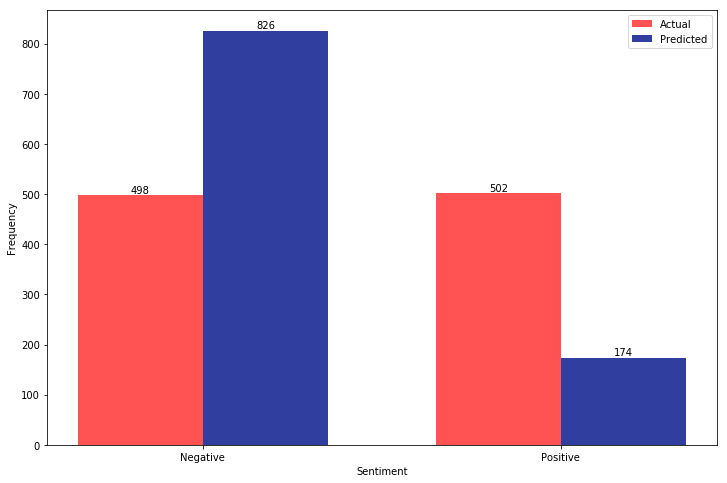

In [76]:
ind = np.arange(2)  # the x locations for the groups
width = 0.35       # the width of the bars
actual  = (n_reviews_actual, p_reviews_actual)
plt.figure(figsize = (12, 8))
fig, ax = plt.subplots(figsize = (12, 8))
rects1 = ax.bar(ind, actual, width, color='#FF5252')

predicted = (n_reviews_predicted, p_reviews_predicted)
rects2 = ax.bar(ind + width, predicted, width, color='#303F9F', linewidth=6)
ax.set_ylabel('Frequency')
ax.set_title('')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Negative', 'Positive'))
ax.set_xlabel('Sentiment')

ax.legend((rects1[0], rects2[0]), ('Actual', 'Predicted'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.savefig('./Output/Working_Feed_Forward_bar_graph.png')
plt.show()

[[424  74]
 [402 100]]


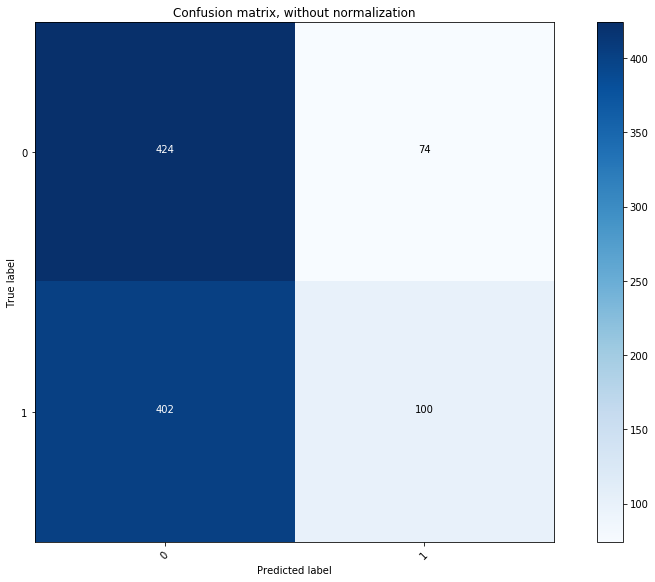

In [79]:
y_actual = list(reviews_df.sentiment.astype('int64').values)
y_pred = list(reviews_df.Predicted_Sentiment.astype('int64').values)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_actual, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 8))
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')
plt.savefig('./Output/Feed_Forward_Confusion_matrix.png')
plt.show()